In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil 

In [ ]:
VIDEOS_PATH = "/content/dataset/raw_videos"
IMAGES_PATH = "/content/dataset/images"
IMAGE_DIMS = (320, 240)
FRAME_SKIP = 1

In [ ]:
dataset = {
    "gate":[
            {"id":"1ZgB6H3BvIpY2hGlxRZyNWqxNzqXEcaOd", "time":[0, 16]},
            {"id":"1-PWKUPQN7fpccPvIP-qwHYOUG7rlIZcg", "time":[9, 19]},
            {"id":"1EC5jTVkmp8F38CekmKGOI5cozlIanap2", "time":[0, 12]}, 
            {"id":"1DYceEMmv_SE-u9a2JeHDdBkE2dbLUykM", "time":[0, 16]},
            {"id":"11i-PGRHadcdM_I_Ac4eY5s1squMjwcSW", "time":[0, 17]},
            {"id":"1Pxg3wq_NI6kixxmiGrN3i8zYY6lSZtCT", "time":[12, 22]},
            {"id":"1DFxOBErILaqwLnUWnp_LAA0w6nrCestE", "time":[0, 13]},
            {"id":"1tkY7PNNUdDmEJEMwtBo1AEGre2ej7-eq", "time":[4, 16]},
            {"id":"1H31XijetfseAYMLRcrgV9zHy97jN5pjJ", "time":[6, None]},
            {"id":"1068GQ6TbXUbnnYdhEp93wEGV-gZND5Si", "time":[0, 12]},
            {"id":"1cyaXGP8Y3ew_kWOAWqY1wqvnSL7LcV-V", "time":[0, 9]},
            {"id":"18G8lNKye2jF4XA9Wp3ayulAWp9t42Lg-", "time":[0, 4]},
            {"id":"1IPJXXQGx1qaLWm21DiQ0Ykf95GeKgLEK", "time":[0, 13]},


            {"id":"1npIbYXxzQ4248YWSHbiZeHTiVGtj2-qG", "time":[2, 12]},
            {"id":"1gWoRZb8TkpEi2Db9BlLYFHNQCXXQCObU", "time":[30, 41]},
            {"id":"1y6JIdFgTv6gmXpr7wNgRq_B6CRmQZNFh", "time":[0, 8]},
            {"id":"1HsKdqkTtDqr03BHxvhrMGYrfey29HJIT", "time":[23, 36]},
            {"id":"1HsKdqkTtDqr03BHxvhrMGYrfey29HJIT", "time":[39, 44]},
            {"id":"1HsKdqkTtDqr03BHxvhrMGYrfey29HJIT", "time":[57, 60]},
            {"id":"1HsKdqkTtDqr03BHxvhrMGYrfey29HJIT", "time":[73, 80]},
            {"id":"1HsKdqkTtDqr03BHxvhrMGYrfey29HJIT", "time":[0, 12]},
            
            {"id":"13BU46vHAALG3vchYreWsftnibYi22jyX", "time":[5, 22]},
            {"id":"13BU46vHAALG3vchYreWsftnibYi22jyX", "time":[31, 48]},
            {"id":"195IVlfMqHFBq9PLGVp9ULgtQSCHJZTV_", "time":[8, 13]}
            
            ],

       
    "non_gate":[
                
                {"id":"1DFxOBErILaqwLnUWnp_LAA0w6nrCestE", "time":[14, None]},
                {"id":"1tkY7PNNUdDmEJEMwtBo1AEGre2ej7-eq", "time":[22, None]},
                # {"id":"1oTNF3aS3Z_UbB6DDlwWButbILlARovl9", "time":[0, None]},
                {"id":"1cyaXGP8Y3ew_kWOAWqY1wqvnSL7LcV-V", "time":[13, None]},
                {"id":"1npIbYXxzQ4248YWSHbiZeHTiVGtj2-qG", "time":[32, None]},
                {"id":"1y6JIdFgTv6gmXpr7wNgRq_B6CRmQZNFh", "time":[20, None]},
                {"id":"18G8lNKye2jF4XA9Wp3ayulAWp9t42Lg-", "time":[6, None]}   ]        
}

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Create dataset directories
os.makedirs(VIDEOS_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

os.makedirs("/content/train/gate", exist_ok=True)
os.makedirs("/content/train/non", exist_ok=True)


os.makedirs("/content/test/gate", exist_ok=True)
os.makedirs("/content/test/non", exist_ok=True)


os.makedirs("/content/validation/gate", exist_ok=True)
os.makedirs("/content/validation/non", exist_ok=True)

In [ ]:
# Loop over classes
for current_class, videos in dataset.items():
  print("Processing {} class.".format(current_class))
  img_idx = 0
  # Create a directory for the class in videos and images path
  os.makedirs(os.path.join(VIDEOS_PATH, current_class), exist_ok=True)
  os.makedirs(os.path.join(IMAGES_PATH, current_class), exist_ok=True)
  os.chdir(os.path.join(VIDEOS_PATH, current_class))
  # Loop over videos in each class
  for index, video in enumerate(videos):
    # Download the video
    downloaded = drive.CreateFile({'id':video["id"]})
    video_name = str(index) + ".mp4"
    print("Processing {}".format(video_name))
    downloaded.GetContentFile(video_name)
    # Open the video
    cap = cv2.VideoCapture(video_name)
    # Get the frame rate
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Get start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, round(fps * video["time"][0]))
    # Get end frame
    if video["time"][1] == None:
      end_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    else:
      end_frame = round(fps * video["time"][1])

    frame_idx = 0

    while cap.isOpened() and cap.get(cv2.CAP_PROP_POS_FRAMES) < end_frame:
      # Read frame
      ret, frame = cap.read()
      if not ret:
        break

      if frame_idx % FRAME_SKIP == 0:
        # Save image
        cv2.imwrite(os.path.join(IMAGES_PATH, current_class, str(img_idx) + ".jpg"), frame)
        img_idx += 1

      frame_idx += 1

    cap.release()

  os.chdir("/content")

Processing gate class.
Processing 0.mp4
Processing 1.mp4
Processing 2.mp4
Processing 3.mp4
Processing 4.mp4
Processing 5.mp4
Processing 6.mp4
Processing 7.mp4
Processing 8.mp4
Processing 9.mp4
Processing 10.mp4
Processing 11.mp4
Processing 12.mp4
Processing 13.mp4
Processing 14.mp4
Processing 15.mp4
Processing 16.mp4
Processing 17.mp4
Processing 18.mp4
Processing 19.mp4
Processing 20.mp4
Processing 21.mp4
Processing 22.mp4
Processing 23.mp4
Processing non_gate class.
Processing 0.mp4
Processing 1.mp4
Processing 2.mp4
Processing 3.mp4
Processing 4.mp4
Processing 5.mp4


In [ ]:
print('number of gate - ',len(os.listdir("/content/dataset/images/gate"))) #printing the number of cat training images
print('number of non  - ',len(os.listdir("/content/dataset/images/non_gate"))) #printing the number of dog training images


number of gate -  3846
number of non  -  4630


 **Data_spliting**

In [ ]:
gate_dir = "/content/dataset/images/gate" #storing the cats training images
non_dir ="/content/dataset/images/non_gate" #storing the cats training images

gate=os.listdir(gate_dir)
non=os.listdir(non_dir)

train_gate = gate[:int(0.8*len(gate))]
train_non = non[:int(0.8*len(non))]

valid_gate = gate [int(0.8*len(gate)):int(0.986*len(gate))]
valid_non= non [int(0.8*len(non)) : int(0.986*len(non))]

test_gate = gate[int(0.986*len(gate)) :int(len(gate))]
test_non = non[int(0.986*len(non)) :int(len(non))]


In [ ]:
print('number of train gate - ',len(train_gate))
print('number of test gate - ',len(test_gate)) 
print('number of valid gate - ',len(valid_gate)) 

print('number of train non - ',len(train_non)) 
print('number of test non - ',len(test_non)) 
print('number of valid non - ',len(valid_non)) 


number of train gate -  3076
number of test gate -  54
number of valid gate -  716
number of train non -  3704
number of test non -  65
number of valid non -  861


In [ ]:
for file in gate:
    if file in train_gate:
        src_dir = gate_dir+'/'+str(file)
        dst_dir = "/content/train/gate"
        shutil.move(src_dir,dst_dir)

    elif file in valid_gate:
        src_dir = gate_dir+'/'+str(file)
        dst_dir = "/content/validation/gate"
        shutil.move(src_dir,dst_dir)
    elif file in test_gate:
        src_dir = gate_dir+'/'+str(file)
        dst_dir = "/content/test/gate"
        shutil.move(src_dir,dst_dir)
    else:
        pass


In [ ]:
for file in non:
    if file in train_non:
        src_dir = non_dir+'/'+str(file)
        dst_dir = "/content/train/non"
        shutil.move(src_dir,dst_dir)

    elif file in valid_non:
        src_dir = non_dir+'/'+str(file)
        dst_dir = "/content/validation/non"
        shutil.move(src_dir,dst_dir)
    elif file in test_non:
        src_dir = non_dir+'/'+str(file)
        dst_dir = "/content/test/non"
        shutil.move(src_dir,dst_dir)
    else:
        pass


In [ ]:
print('number of train gate - ',len(os.listdir("/content/train/gate"))) 
print('number of train non  - ',len(os.listdir("/content/train/non")))

print('number of test gate - ',len(os.listdir("/content/test/gate"))) 
print('number of test non - ',len(os.listdir("/content/test/non")))

print('number of valid gate  - ',len(os.listdir("/content/validation/gate"))) 
print('number of valid non - ',len(os.listdir("/content/validation/non"))) 



number of train gate -  3076
number of train non  -  3704
number of test gate -  54
number of test non -  65
number of valid gate  -  716
number of valid non -  861


**CNN_Model**

In [ ]:
import pandas as pd #making some of our usual imports inorder to solve the problem in hand 
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential #importing our deep learing libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_generator = ImageDataGenerator(rescale = 1./250,zoom_range = 0.2) #we are converting our RGB photo into array numbers for better computation and processing of our model


In [ ]:
batch_size = 64 #accessing all our data both training and testing
training_data = data_generator.flow_from_directory(directory = "/content/train",
                                                  target_size = (150,150),
                                                  batch_size = batch_size,
                                                  class_mode  = 'binary')

validation_data = data_generator.flow_from_directory(directory = "/content/validation",
                                                  target_size = (150,150),
                                                  batch_size = batch_size,
                                                  class_mode  = 'binary')

Found 6780 images belonging to 2 classes.
Found 1577 images belonging to 2 classes.


In [ ]:
model = Sequential() #making our CNN
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = training_data.image_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.3))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))
model.add(Conv2D(filters = 126, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.15))
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.15))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = len(set(training_data.classes)), activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
fitted_model = model.fit_generator(training_data,
                        steps_per_epoch = 105,
                        epochs =3,
                        validation_data = validation_data,
                        validation_steps = 24)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
105/105 [==============================] - 257s 2s/step - loss: 0.4370 - accuracy: 0.8346 - val_loss: 0.1243 - val_accuracy: 0.9701
Epoch 2/3
105/105 [==============================] - 256s 2s/step - loss: 0.0399 - accuracy: 0.9879 - val_loss: 0.0242 - val_accuracy: 0.9922
Epoch 3/3
105/105 [==============================] - 258s 2s/step - loss: 0.0260 - accuracy: 0.9915 - val_loss: 0.0248 - val_accuracy: 0.9948


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 126)       7

In [ ]:
def testing_image(image_directory): #testing out our model
    test_image = image.load_img(image_directory, target_size = (150, 150))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(x = test_image)
    if result[0][0]  == 1:
        prediction = 'gate'
        # print(prediction)
        return 1
    else:
        prediction = 'none gate'
        # print(prediction)
        return 0
    

In [ ]:
test_dir = "/content/test" 

In [ ]:
print('number of test non - ',len(os.listdir("/content/test/gate")))
test_gate=os.listdir("/content/test/gate")
test_non=os.listdir("/content/test/non")

number of test non -  54


In [ ]:
TP=0
FP=0
for file in test_gate:
    x=testing_image(test_dir + '/gate/' + str(file))
    if x==1 :
        TP+=1
    else:
        FP+=1

print(TP,FP)

    

54 0


In [ ]:
print('number of test non - ',len(os.listdir("/content/test/non")))

number of test non -  65


In [ ]:
TN=0
FN=0
for file in test_non:
    x=testing_image(test_dir + '/non/' + str(file))
    if x==0 :
        TN+=1
    else:
        FN+=1

print(TN,FN)


56 9


In [ ]:
test_Accuracy=(TP+TN)/(TP+TN+FP+FN)
print(test_Accuracy)

0.9243697478991597


In [ ]:
model.save("CNN.model")

INFO:tensorflow:Assets written to: CNN.model/assets


In [ ]:
!zip -r GateDetection_NeuralNetwork.zip CNN.model

  adding: CNN.model/ (stored 0%)
  adding: CNN.model/saved_model.pb (deflated 89%)
  adding: CNN.model/assets/ (stored 0%)
  adding: CNN.model/variables/ (stored 0%)
  adding: CNN.model/variables/variables.index (deflated 67%)
  adding: CNN.model/variables/variables.data-00000-of-00001 (deflated 9%)


In [ ]:
# print(testing_image("/content/download.jpeg"))

In [24]:
cf_matrix = ([[TN,  FP],
       [ FN, TP]])

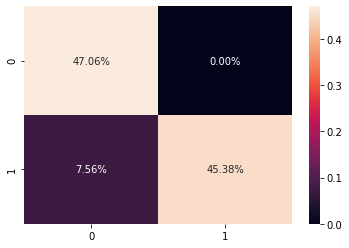

In [37]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%')
